In [21]:
import requests
from contextlib import closing
import csv

url = "https://data.ny.gov/api/views/9a8c-vfzj/rows.csv?accessType=DOWNLOAD"

In [22]:
import re
from shapely.wkt import dumps, loads
regex = re.compile(r"[+-]?\d+(?:\.\d+)?")
def to_geom(raw):
    numbers = regex.findall(raw)
    try:
        if len(numbers) > 1:
            lat, lng = numbers[-2:]
            return loads("Point({} {})".format(lat, lng))
    except:
        return None
type(to_geom('NY 11223(40.59612, -73.98113)'))

shapely.geometry.point.Point

In [23]:
with closing(requests.get(url, stream=True)) as r:
    reader = [x for x in csv.reader(r.iter_lines(), delimiter=',')]
header = reader.pop(0)
print header
print reader[0]

['County', 'License Number', 'Operation Type', 'Establishment Type', 'Entity Name', 'DBA Name', 'Street Number', 'Street Name', 'Address Line 2', 'Address Line 3', 'City', 'State', 'Zip Code', 'Square Footage', 'Location']
['Kings', '617635', 'Store', 'A     ', 'DOLLAR FLOW INC                  ', '99 CENT RUSH           ', '260', 'PROSPECT PARK W        ', '             ', '               ', 'BROOKLYN          ', 'NY', '11215', '3000', '260 PROSPECT PARK WBROOKLYN, NY 11215(40.658597, -73.981943)']


In [24]:
geometries = map(lambda x: to_geom(x[-1]), reader)

In [25]:
import geopandas as pd
df = pd.GeoDataFrame(reader, columns=header, geometry=geometries)

In [26]:
nyc = df[df['County'] == "Kings"]
df.head()

,County,License Number,Operation Type,Establishment Type,Entity Name,DBA Name,Street Number,Street Name,Address Line 2,Address Line 3,City,State,Zip Code,Square Footage,Location,geometry
0,Kings,617635,Store,A,DOLLAR FLOW INC,99 CENT RUSH,260,PROSPECT PARK W,,,BROOKLYN,NY,11215,3000,"260 PROSPECT PARK WBROOKLYN, NY 11215(40.65859...",POINT (40.658597 -73.981943)
1,Kings,619122,Store,JAC,SLOPE FOODS INC,SLOPE FOODS,61,5TH AVE,,,BROOKLYN,NY,11217,1200,"61 5TH AVEBROOKLYN, NY 11217(40.680987, -73.97...",POINT (40.680987 -73.977369)
2,Kings,619765,Store,JAC,WIESNERS FOOD CENTER INC,WIESNERS SUPERMARKET,5918,18TH AVE,,,BROOKLYN,NY,11204,2000,"5918 18TH AVEBROOKLYN, NY 11204(40.622152, -73...",POINT (40.622152 -73.987132)
3,Kings,617316,Store,JAC,GOBWA EXOTIC IMPORTS INC,GOBWA EXOTIC IMPORTS,1127,NOSTRAND AVE,,,BROOKLYN,NY,11225,2000,"1127 NOSTRAND AVEBROOKLYN, NY 11225(40.660119,...",POINT (40.660119 -73.950579)
4,Kings,612560,Store,JAC,SURIEL JOSE R,LAST STOP GROCERY STORE,5316,3RD AVE,,,BROOKLYN,NY,11220,1500,"5316 3RD AVEBROOKLYN, NY 11220(40.6457, -74.01...",POINT (40.6457 -74.01689500000001)


In [51]:
def calc_length(row):
    if row['geometry']:
        return barclays.distance(row['geometry'])
    else:
        return -1

nyc['distance'] = nyc.apply(calc_length,axis=1)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [29]:
filtered = nyc[nyc['geometry'] != None]
filtered.head()

,County,License Number,Operation Type,Establishment Type,Entity Name,DBA Name,Street Number,Street Name,Address Line 2,Address Line 3,City,State,Zip Code,Square Footage,Location,geometry,distance
0,Kings,617635,Store,A,DOLLAR FLOW INC,99 CENT RUSH,260,PROSPECT PARK W,,,BROOKLYN,NY,11215,3000,"260 PROSPECT PARK WBROOKLYN, NY 11215(40.65859...",POINT (40.658597 -73.981943),0.025332
1,Kings,619122,Store,JAC,SLOPE FOODS INC,SLOPE FOODS,61,5TH AVE,,,BROOKLYN,NY,11217,1200,"61 5TH AVEBROOKLYN, NY 11217(40.680987, -73.97...",POINT (40.680987 -73.977369),0.002568
2,Kings,619765,Store,JAC,WIESNERS FOOD CENTER INC,WIESNERS SUPERMARKET,5918,18TH AVE,,,BROOKLYN,NY,11204,2000,"5918 18TH AVEBROOKLYN, NY 11204(40.622152, -73...",POINT (40.622152 -73.987132),0.062087
3,Kings,617316,Store,JAC,GOBWA EXOTIC IMPORTS INC,GOBWA EXOTIC IMPORTS,1127,NOSTRAND AVE,,,BROOKLYN,NY,11225,2000,"1127 NOSTRAND AVEBROOKLYN, NY 11225(40.660119,...",POINT (40.660119 -73.950579),0.034520
4,Kings,612560,Store,JAC,SURIEL JOSE R,LAST STOP GROCERY STORE,5316,3RD AVE,,,BROOKLYN,NY,11220,1500,"5316 3RD AVEBROOKLYN, NY 11220(40.6457, -74.01...",POINT (40.6457 -74.01689500000001),0.055393


In [30]:
import pandas as opd
sample = filtered.loc[:, ['distance', 'Square Footage', 'geometry']]
sample['Square Footage'] = sample['Square Footage'].apply(opd.to_numeric)
print sample.corr()
print sample.describe()

                distance  Square Footage
distance        1.000000       -0.010566
Square Footage -0.010566        1.000000
           distance  Square Footage
count   5049.000000     5049.000000
mean      40.381933     2399.029709
std      674.270349     7416.359228
min       -1.000000        0.000000
25%        0.038215      500.000000
50%        0.054441     1200.000000
75%        0.074966     2000.000000
max    11496.199688   230000.000000


In [12]:
# from tpot import TPOTRegressor
# from sklearn.datasets import load_boston
# from sklearn.model_selection import train_test_split

# X = sample.drop('Square Footage', axis=1).values
# X = sample.loc[:, 'distance'].values 
# y = sample.loc[:, 'Square Footage'].values 
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     train_size=0.75, test_size=0.25)

# tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2)
# tpot.fit(X_train, y_train)
# print(tpot.score(X_test, y_test))
# tpot.export('tpot_nyc_retail.py')

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

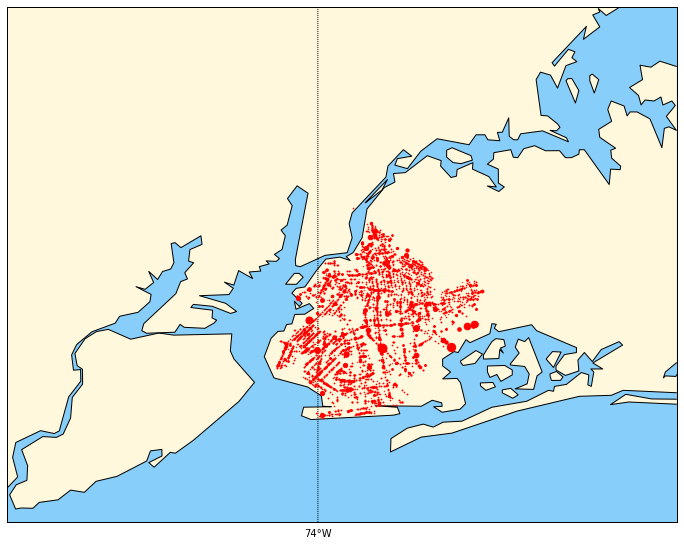

In [50]:
LOW_LEFT_CORNR_LONGITUDE = -74.260380
LOW_LEFT_CORNER_LATITUDE = 40.485808
UP_RIGHT_CORNER_LONGITUDE = -73.699206
UP_RIGHT_CORNER_LATITUDE = 40.917691
water = 'lightskyblue'
earth = 'cornsilk'
barclays_lon, barclays_lat = -73.976188, 40.683267
 
fig, ax1 = plt.subplots(figsize=(12, 10))
mm = Basemap(
    llcrnrlon=LOW_LEFT_CORNR_LONGITUDE,
    llcrnrlat=LOW_LEFT_CORNER_LATITUDE,
    urcrnrlon=UP_RIGHT_CORNER_LONGITUDE,
    urcrnrlat=UP_RIGHT_CORNER_LATITUDE,
    ellps='WGS84',
    resolution='h',
    area_thresh=0.6)
coast = mm.drawcoastlines()
rivers = mm.drawrivers(color=water, linewidth=1.5)
continents = mm.fillcontinents(
    color=earth,
    lake_color=water)
bound= mm.drawmapboundary(fill_color=water)
countries = mm.drawcountries()
rivers = mm.drawrivers()
merid = mm.drawmeridians(
    np.arange(-180, 180, 2), 
    labels=[False, False, False, True])
parall = mm.drawparallels(
    np.arange(0, 80), 
    labels=[True, True, False, False])
stores = []
for i, row in enumerate(sample.values):
    row = list(row)
    if row[-1] is not None:
        x, y = mm(row[-1].y, row[-1].x)
        size = (row[1]/230000.0) * 80 if row[1] else 0
        stores.append(mm.scatter(x, y, size, label="test", color='red', zorder=100))
    